In [ ]:
!pip uninstall keras
!pip install q keras==2.0.8
!pip uninstall tensorflow
!pip install tensorflow==1.13.2

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


In [2]:
import keras
from keras.layers import(Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape)
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [5]:
img_width = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

In [6]:
latent_dim = 2

In [ ]:
input_img = Input(shape = input_shape, name = 'encoder_input')
x = Conv2D(32, 3, padding = 'same', activation = 'relu')(input_img)
x = Conv2D(64, 3, padding = 'same', activation = 'relu', strides = (2, 2))(x)
x = Conv2D(64, 3, padding = 'same', activation = 'relu')(x)
x = Conv2D(64, 3, padding = 'same', activation = 'relu')(x)

In [8]:
conv_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation = 'relu')(x)

In [9]:
z_mu = Dense(latent_dim, name = 'latent_mu')(x)
z_sigma = Dense(latent_dim, name = 'latent_sigma')(x)

In [10]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape = (K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [11]:
z = Lambda(sample_z, output_shape = (latent_dim, ), name = 'z')([z_mu, z_sigma])

In [12]:
encoder = Model(input_img, [z_mu, z_sigma, z], name = 'encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

In [13]:
decoder_input = Input(shape = (latent_dim, ), name = 'decoder_input')

In [14]:
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation = 'relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding = 'same', activation = 'relu', strides = (2, 2))(x)
x = Conv2DTranspose(num_channels, 3, padding = 'same', activation = 'sigmoid', name = 'decoder_output')(x)

In [15]:
decoder = Model(decoder_input, x, name = 'decoder')
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
z_decoded = decoder(z)

In [17]:
#Custom Loss - Reconstruction Loss + KL div. loss
class CustomLayer(keras.layers.Layer):

  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)

    recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

    #We can add Beta trainable param to kl_loss
    kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis = -1)

    return K.mean(recon_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs = inputs)
    return x 

In [18]:
y = CustomLayer()([input_img, z_decoded])

In [19]:
vae = Model(input_img, y, name = 'vae')
vae.compile(optimizer = 'adam', loss = None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
________________________________________________________________________________________________

/tensorflow-1.15.2/python3.7/keras/engine/training_utils.py:819: UserWarning: Output custom_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [20]:
vae.fit(x_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 30s 617us/step - loss: 0.2351 - val_loss: 0.2097
Epoch 2/10
48000/48000 [==============================] - 23s 482us/step - loss: 0.2026 - val_loss: 0.1971
Epoch 3/10
48000/48000 [==============================] - 23s 483us/step - loss: 0.1953 - val_loss: 0.1923
Epoch 4/10
48000/48000 [==============================] - 23s 482us/step - loss: 0.1917 - val_loss: 0.1901
Epoch 5/10
48000/48000 [==============================] - 23s 484us/step - loss: 0.1894 - val_loss: 0.1880
Epoch 6/10
48000/48000 [==============================] - 23s 486us/step - loss: 0.1877 - val_loss: 0.1867
Epoch 7/10
48000/48000 [==============================] - 23s 482us/step - loss: 0.1864 - val_loss: 0.1855
Epoch 8/10
48000/48000 [==============================] - 23s 482us/step - loss: 0.1852 - val_loss: 0.1846

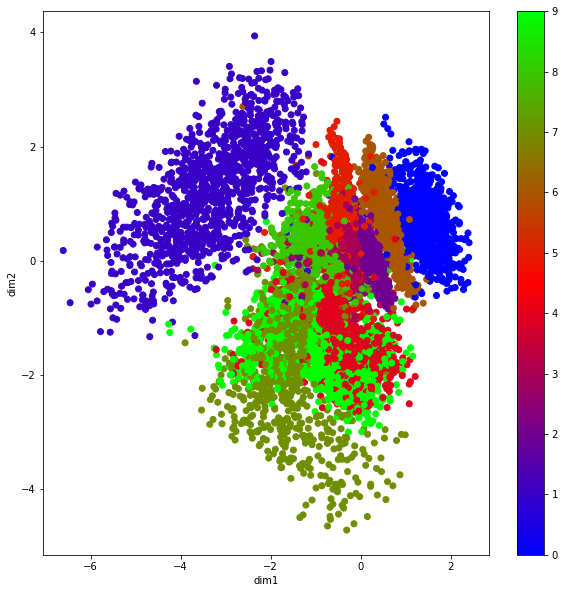

In [21]:
mu, _, _ = encoder.predict(x_test)

plt.figure(figsize = (10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c = y_test, cmap = 'brg')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.colorbar()
plt.show()

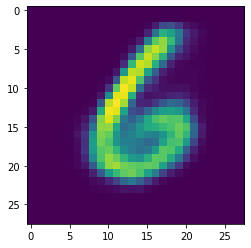

In [24]:
sample_vector = np.array([[0.5, 1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

In [39]:
n = 20
figure = np.zeros((img_width*n, img_height*n, num_channels))

grid_x = np.linspace(-5, 2.5, n)
grid_y = np.linspace(-4, 4, n)[::-1]

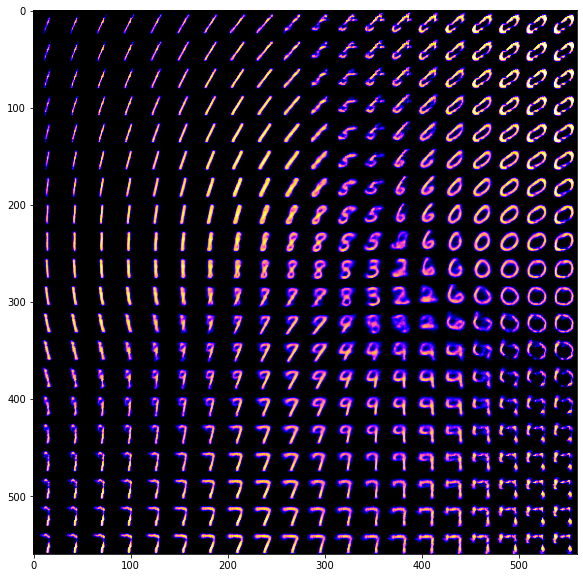

In [48]:
%matplotlib 3.0.1
for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):
    z_sample = np.array([[xi, yi]])
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(img_width, img_height)
    figure[i*img_width: (i+1)*img_width,
           j*img_height: (j+1)*img_height] = digit

plt.figure(figsize = (10, 10))
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap = 'gnuplot2')
plt.imshow()